In [1]:
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import VQR
from sklearn.preprocessing import MinMaxScaler
from qiskit.circuit.library import RealAmplitudes
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


/tmp/ipykernel_16965/3682439162.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

def normalize_skewed_columns(dataframe):
    """
    Normalize all right-skewed columns in a DataFrame using logarithmic transformation.

    Args:
    dataframe: A pandas DataFrame with right-skewed numeric columns.
    """
    columns = dataframe.select_dtypes(include=[np.number]).columns
    # Apply log transformation to each column
    for col in columns:
        # Check if all values in the column are positive and non-zero
        if (dataframe[col] > 0).all():
            dataframe[col] = np.log(dataframe[col])
        else:
            # Handle non-positive values, if any
            min_val = dataframe[col].min()
            dataframe[col] = np.log(dataframe[col] - min_val + 1)

    return dataframe



In [3]:

def standardize_numeric_features(df):
    """
    Standardize numeric features in a DataFrame.

    Args:
    df: A pandas DataFrame.

    Returns:
    A DataFrame with standardized numeric features.
    """
    scaler = StandardScaler()

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Standardize the numeric columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df



In [4]:
try:
    abnbnyc = pd.read_csv('AB_NYC_2019.csv')
except:
    # read raw pkl file
    abnbnyc = pd.read_pickle('AB_NYC_2019.pkl')
# drop columns that are not useful for the analysis
abnbnyc.drop(['id', 'host_name', 'name', 'last_review',"neighbourhood",'host_id','calculated_host_listings_count'], axis=1,
             inplace=True, errors='ignore')
# drop rows with missing values and replace missing values in reviews_per_month with 0
abnbnyc.fillna({'reviews_per_month': 0}, inplace=True)
abnbnyc['minimum_nights'].replace(0, 1, inplace=True)
abnbnyc.drop(abnbnyc[abnbnyc['price'] == 0].index, inplace=True)

# drop rows with price > 500
abnbnyc = abnbnyc[abnbnyc['price'] <= 500]
# set the data types of the categorical columns
abnbnyc['neighbourhood_group'] = abnbnyc['neighbourhood_group'].astype('category')
abnbnyc['room_type'] = abnbnyc['room_type'].astype('category')
# feature engineering
abnbnyc['min_price'] = abnbnyc['price'] * abnbnyc['minimum_nights']
abnbnyc['review_ratio'] = abnbnyc['number_of_reviews'] / abnbnyc['reviews_per_month']
abnbnyc['review_ratio'].fillna(0, inplace=True)

# normalize the skewed columns
normalized_df = normalize_skewed_columns(abnbnyc.drop(['price'], axis=1))
normalized_df['price'] = abnbnyc['price']

# standardize the numeric columns
standardized_df = standardize_numeric_features(normalized_df.drop(['price'], axis=1))
standardized_df['price'] = normalized_df['price']

# encode the categorical columns
standardized_df_encoded = pd.get_dummies(standardized_df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

X = standardized_df_encoded.drop(['price'], axis=1)
y = standardized_df_encoded['price']


/tmp/ipykernel_16965/2031606139.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  abnbnyc['minimum_nights'].replace(0, 1, inplace=True)
/tmp/ipykernel_16965/2031606139.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [5]:
X_xxs= X[:10]
y_xxs = y[:10]
X_xs = X[:100]
y_xs = y[:100]
X_small=X[:1000]
y_small=y[:1000]

In [6]:
objective_func_vals = []

### Method to draw the objective function value against iteration

In [7]:
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
# the features represent the data of the dataset
features=X_xxs
true_y=np.array(y_xxs)
#normalize the features
features = MinMaxScaler().fit_transform(features)
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
# feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


In [9]:

ansatz = RealAmplitudes(num_qubits=num_features, reps=2)


In [10]:

vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)


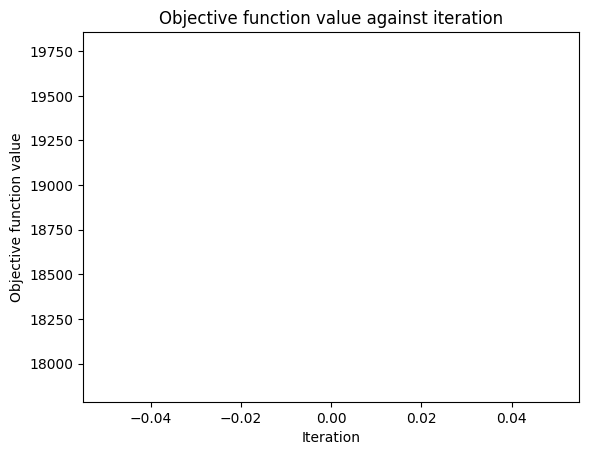

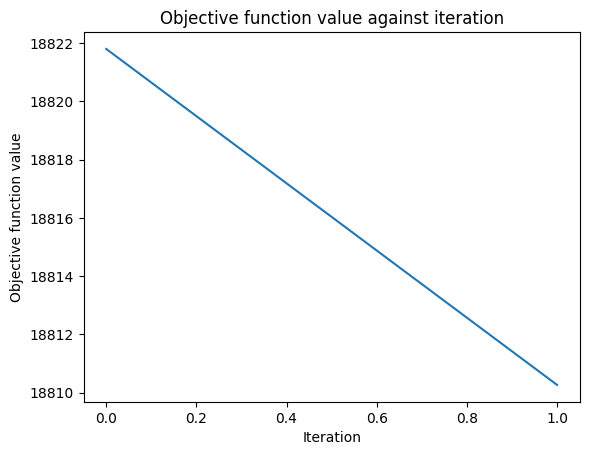

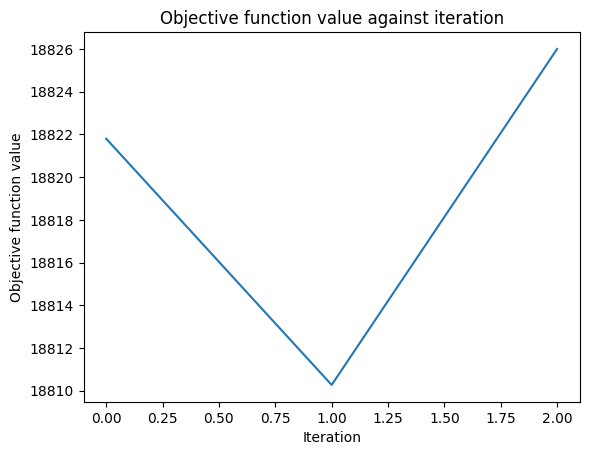

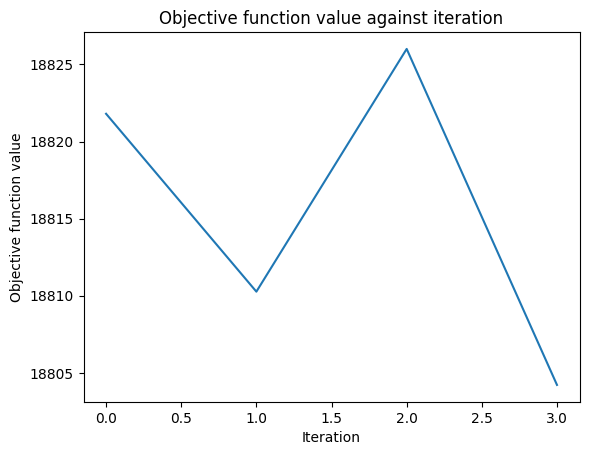

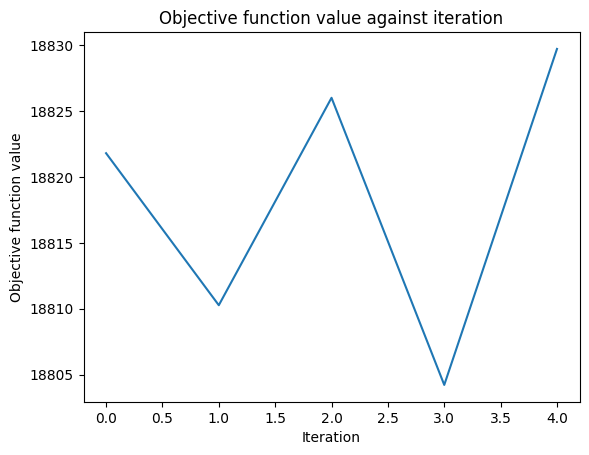

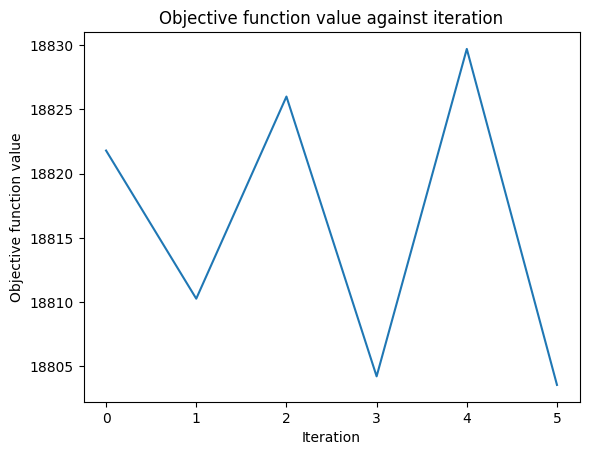

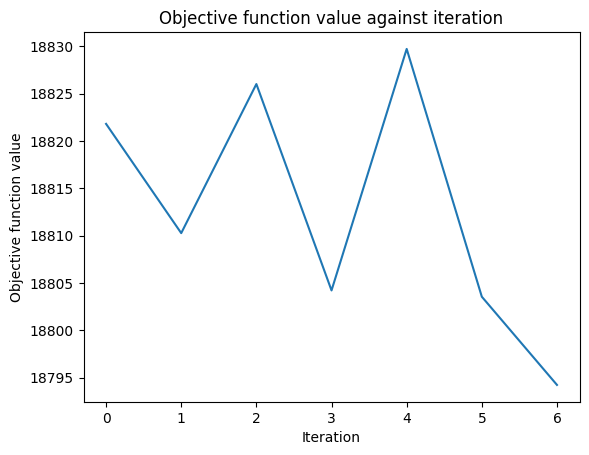

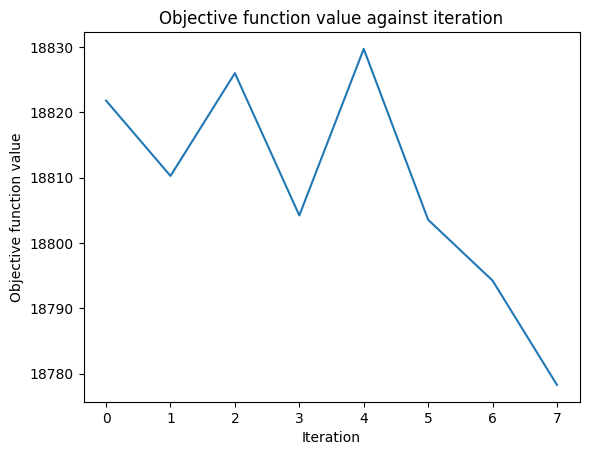

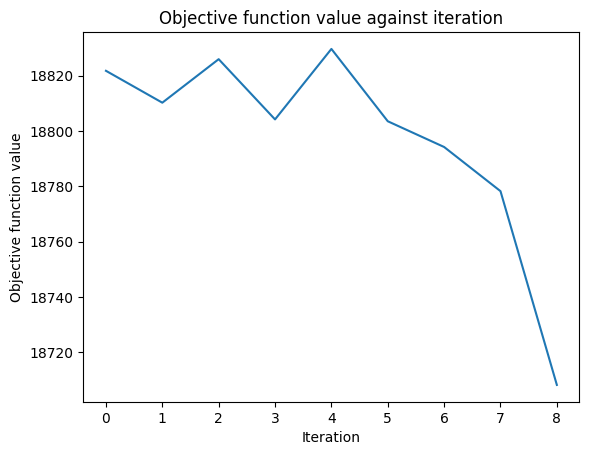

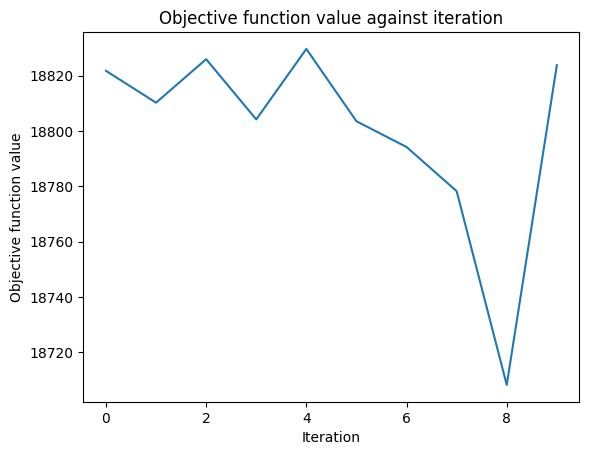

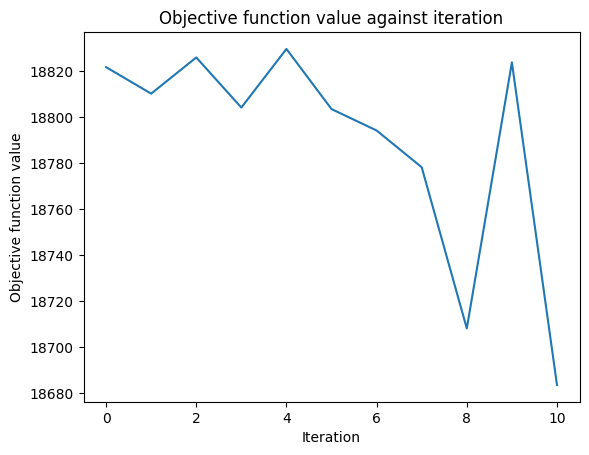

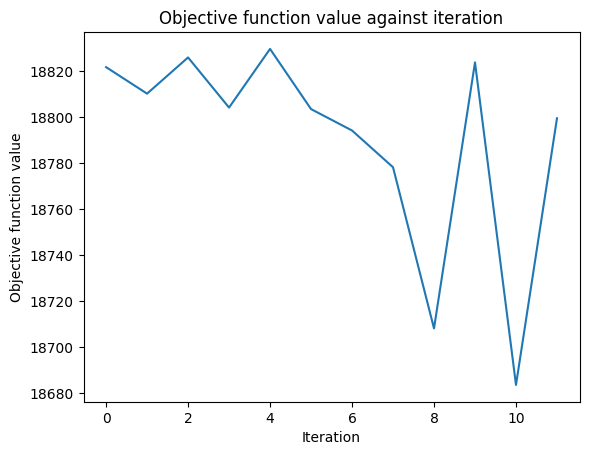

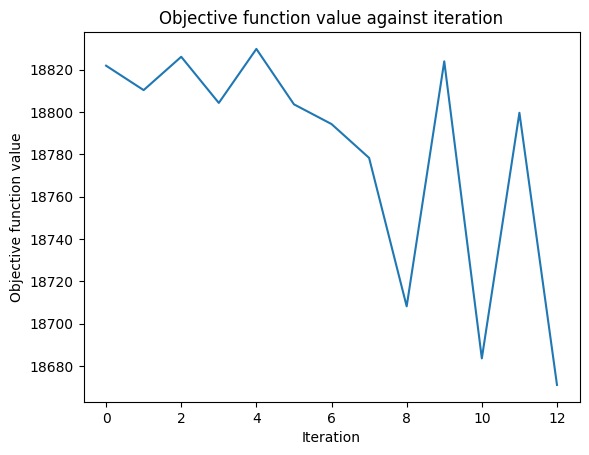

In [11]:
vqr_result = vqr.fit(features, true_y)

In [12]:

vqr.score(features, true_y)

-5.390497898445889